In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

input_path = '/Users/danasour/PycharmProjects/GLUSAP/notebooks/results'

adults = ['adult#001', 'adult#002', 'adult#004', 'adult#005', 'adult#008', 'adult#009', 'adult#010']

adult_info = {
    'adult#001': {'CR': 10, 'CF': 8.77, 'Age': 61, 'TDI': 50.42},
    'adult#002': {'CR': 8, 'CF': 9.21, 'Age': 65, 'TDI': 57.87},
    'adult#004': {'CR': 16, 'CF': 42.65, 'Age': 66, 'TDI': 33.81},
    'adult#005': {'CR': 5, 'CF': 8.23, 'Age': 52, 'TDI': 68.32},
    'adult#008': {'CR': 13, 'CF': 12.25, 'Age': 48, 'TDI': 42.78},
    'adult#009': {'CR': 5, 'CF': 7.64, 'Age': 68, 'TDI': 67.21},
    'adult#010': {'CR': 5, 'CF': 10.69, 'Age': 68, 'TDI': 64.45}
}

def get_data(adult, input_path, days=0):
    data = []
    for i in range(1, 14):
        path = os.path.join(input_path, f'simulation_{i}', adult)
        df = pd.read_csv(path)
        df['Time'] = pd.to_datetime(df['Time'])
        # sum 1 day to the date
        df['Time'] = df['Time'] + pd.DateOffset(days=days)
        days = days + 1
        data.append(df)
    return pd.concat(data)

adult = 'adult#001.csv'
input_path = '/Users/danasour/PycharmProjects/GLUSAP/notebooks/results'
data = get_data(adult, input_path)


In [2]:
adult_static_info = adult_info['adult#001']
data['CR'] = adult_static_info['CR']
data['CF'] = adult_static_info['CF']
data['Age'] = adult_static_info['Age']
data['TDI'] = adult_static_info['TDI']

Epoch [10/100], Loss: 0.0283
Epoch [20/100], Loss: 0.0181
Epoch [30/100], Loss: 0.0150
Epoch [40/100], Loss: 0.0088
Epoch [50/100], Loss: 0.0043
Epoch [60/100], Loss: 0.0028
Epoch [70/100], Loss: 0.0022
Epoch [80/100], Loss: 0.0016
Epoch [90/100], Loss: 0.0014
Epoch [100/100], Loss: 0.0012


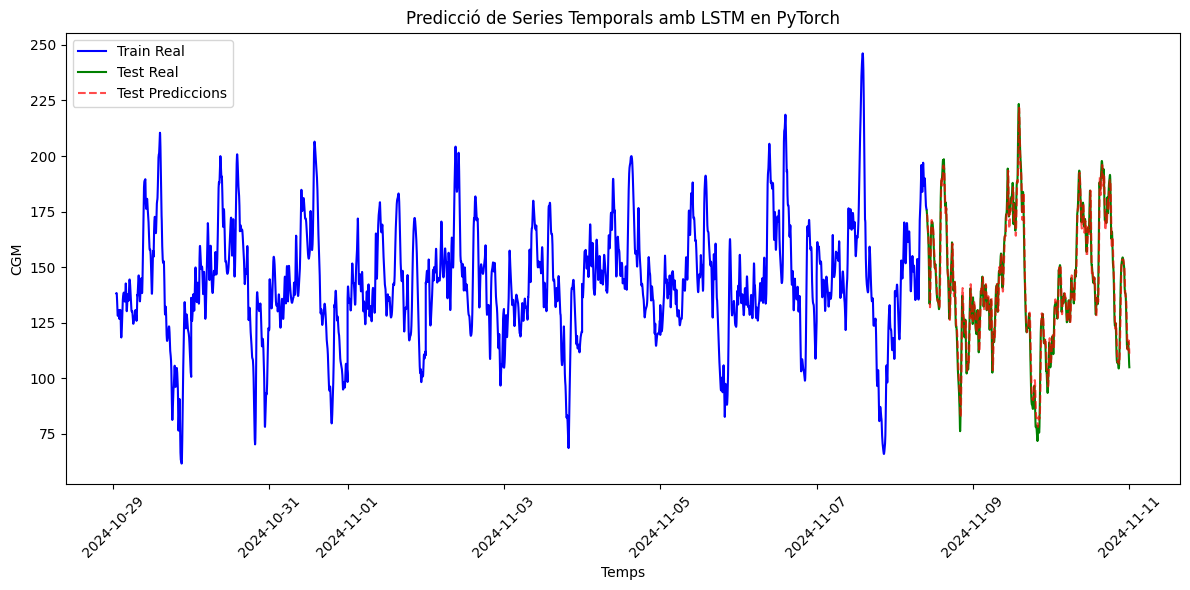

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


scaler = MinMaxScaler(feature_range=(0, 1))
targets = data['CGM'].values  # Obtener la serie temporal para la predicción
targets_normalized = scaler.fit_transform(targets.reshape(-1, 1)).flatten()  # Normaliza y aplana

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20  # Longitud de la seqüència d'entrada
split_ratio = 0.8  # Percentatge de `train`

X, y = create_sequences(targets_normalized, SEQ_LENGTH)

train_size = int(len(X) * split_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_tensor = torch.FloatTensor(X_train).view(-1, SEQ_LENGTH, 1)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).view(-1, SEQ_LENGTH, 1)
y_test_tensor = torch.FloatTensor(y_test)

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)
    test_predictions = model(X_test_tensor)

train_predictions = scaler.inverse_transform(train_predictions.numpy())
y_train_true = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test_true = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(data['Time'][SEQ_LENGTH:train_size+SEQ_LENGTH], y_train_true, label='Train Real', color='blue')
plt.plot(data['Time'][train_size+SEQ_LENGTH:], y_test_true, label='Test Real', color='green')
plt.plot(data['Time'][train_size+SEQ_LENGTH:], test_predictions, label='Test Prediccions', linestyle='--', color='red', alpha=0.7)
plt.legend()
plt.title('Predicció de Series Temporals amb LSTM en PyTorch')
plt.xlabel('Temps')
plt.ylabel('CGM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()